In [1]:
import pdb
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import pylab as plt
from astropy.wcs import WCS
from astropy.io import fits
import readcol
from utils import shift_twod
from utils import dist_idl
from utils import loggen
from utils import gauss_kern
from lmfit import Parameters, minimize, fit_report
#from simstack.simstack import stack_libraries_in_redshift_slices
from simstack.simstack import stack_multiple_fields_in_redshift_slices
from skymaps import Skymaps
from skymaps import Field_catalogs

%matplotlib inline  

In [2]:
popcolor=['blue','red','green','orange','black','grey','chocolate','darkviolet','pink','magenta','dodgerblue','lavender','blue','red','green','orange','black','grey','chocolate','darkviolet','pink','magenta','dodgerblue','lavender']

In [3]:
z_lo = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
z_hi = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
z_nodes = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
z_mid = (z_nodes[:-1] + z_nodes[1:])/2
nz = len(z_nodes) - 1

m_lo = np.array([8.5, 9.5,10.0,10.5,11.0])
m_hi = np.array([9.5,10.0,10.5,11.0,13.0])
m_nodes = np.array([8.5, 9.5,10.0,10.5,11.0,13.0])

#m_lo = np.array([8.5])
#m_hi = np.array([13.0])
#m_nodes = np.array([8.5,13.0])

m_mid = (m_nodes[:-1] + m_nodes[1:])/2
nm = len(m_nodes) - 1

In [4]:
## Map Directories 
## FIND COSMOS maps in http://www.astro.caltech.edu/viero/Jason/cosmos/

dir_spitzer_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_spire_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_pacs_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_aztec_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'

## Dictionary Names
cosmos_library_keys =['cosmos_mips24'
               ,'cosmos_pacs_green'
               ,'cosmos_pacs_red'
               ,'cosmos_spire_PSW'
               ,'cosmos_spire_PMW'
               ,'cosmos_spire_PLW'
               ,'cosmos_aztec'
              ]

cosmos_wv0 = [0,1,1,1,1,1,1]
cosmos_wv0 = [0,0,0,1,0,1,0]
cosmos_wv0 = [0,1,0,1,1,1,1]

cosmos_indstack = np.where(np.array(cosmos_wv0) == 1)
cosmos_wavelength=[24,100,160,250,350,500,1100]
cosmos_fwhm =[6.32,7.4, 11.3,18.1, 25.2, 36.6,18.]
cosmos_efwhm=[6.32,6.7, 11.2,17.6, 23.9, 35.2,18.] # want to the measured effective FWHM later
cosmos_color_correction=[1.25,23.58,23.82,1.018,0.9914,0.95615,1.0]
cosmos_beam_area = [1.54756e-09,1.,1.,1.,1.,1.,1.] #sr

pixsize_suffix = '4.0_arcsec_pixels'

cosmos_maps = [dir_spitzer_maps+'mips_24_GO3_sci_10.cutout.fits' 
        ,dir_pacs_maps+'pep_COSMOS_green_Map.DR1.sci.cutout.fits'
        ,dir_pacs_maps+'pep_COSMOS_red_Map.DR1.sci.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PSW.signal.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PMW.signal.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PLW.signal.cutout.fits'
        ,dir_aztec_maps+'cosmos_jcmt_kscott20100925_map.cutout.fits'
       ]
cosmos_noises = [dir_spitzer_maps+'mips_24_GO3_unc_10.cutout.fits' 
        ,dir_pacs_maps+'pep_COSMOS_green_Map.DR1.err.cutout.fits'
        ,dir_pacs_maps+'pep_COSMOS_red_Map.DR1.err.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PSW.noise.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PMW.noise.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PLW.noise.cutout.fits'
        ,dir_aztec_maps+'cosmos_jcmt_kscott20100925_noise.cutout.fits'
       ]
## Map Directories
## FIND UDS MAPS IN http://www.astro.caltech.edu/viero/william/
###############
dir_spitzer_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_spire_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_pacs_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_aztec_maps = '/Users/marco/Code/Python/Modules/simstack/data/'

## Dictionary Names
uds_library_keys =['uds_mips24'
               ,'uds_pacs_green'
               ,'uds_pacs_red'
               ,'uds_spire_PSW'
               ,'uds_spire_PMW'
               ,'uds_spire_PLW'
               ,'uds_aztec'
              ]

uds_wv0 = [0,1,1,1,1,1,1]
uds_wv0 = [0,0,0,1,0,1,0]
uds_wv0 = [0,1,0,1,1,1,1]

uds_indstack = np.where(np.array(uds_wv0) == 1)
uds_wavelength=[24,100,160,250,350,500,1100]
uds_fwhm =[6.32,7.4, 11.3,18.1, 25.2, 36.6,18.]
uds_efwhm=[6.32,6.7, 11.2,17.6, 23.9, 35.2,18.] # want to the measured effective FWHM later
uds_color_correction=[1.25,23.58,23.82,1.018,0.9914,0.95615,1.0]
uds_beam_area = [1.54756e-09,1.,1.,1.,1.,1.,1.] #sr

#pixsize_suffix = '4.0_arcsec_pixels'

uds_maps = [dir_spitzer_maps+'mips_mosaic.cutout.fits' 
        ,dir_pacs_maps+'UDS_level4_GRN_Unimap_img_wgls.cutout.fits'
        ,dir_pacs_maps+'UDS_level4_RED_Unimap_img_wgls.cutout.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PSW.signal.cutout.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PMW.signal.cutout.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PLW.signal.cutout.fits'
        ,dir_aztec_maps+'sxdf_aste_kscott20100924_map.fits'
       ]
uds_noises = [dir_spitzer_maps+'mips_mosaic_unc.cutout.fits' 
        ,dir_pacs_maps+'UDS_level4_GRN_Unimap_cove_gls.cutout.fits'
        ,dir_pacs_maps+'UDS_level4_RED_Unimap_cove_gls.cutout.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PSW.noise.cutout.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PMW.noise.cutout.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PLW.noise.cutout.fits'
        ,dir_aztec_maps+'sxdf_aste_kscott20100924_map_noise.fits'
       ]

wv0 = cosmos_wv0+uds_wv0
library_keys = cosmos_library_keys + uds_library_keys
maps = cosmos_maps+uds_maps
noises = cosmos_noises+uds_noises
efwhm = cosmos_efwhm+uds_efwhm
color_correction = cosmos_color_correction + uds_color_correction
wavelength = cosmos_wavelength + uds_wavelength
beam_area = cosmos_beam_area + uds_beam_area 

indstack = np.where(np.array(wv0) == 1)
uwavelength = np.unique(np.array(wavelength)[indstack])
nwv = len(uwavelength)

In [5]:
sky_library_gaussians={}
for t in range(len(wv0)):
    #print t
    if wv0[t] == 1:
        print library_keys[t]
        sky_library_gaussians[library_keys[t]] = Skymaps(maps[t],noises[t],efwhm[t],color_correction=color_correction[t])
        sky_library_gaussians[library_keys[t]].add_wavelength(wavelength[t])
        sky_library_gaussians[library_keys[t]].add_fwhm(efwhm[t])
        if beam_area[t] != 1: sky_library_gaussians[library_keys[t]].beam_area_correction(beam_area[t])

cosmos_pacs_green
cosmos_spire_PSW
cosmos_spire_PMW
cosmos_spire_PLW
cosmos_aztec
uds_pacs_green
uds_spire_PSW
uds_spire_PMW
uds_spire_PLW
uds_aztec


In [6]:
path_uds_catalog = '/Users/marco/Documents/Publications/my_old_publications/k_band_stacking_paper/catalogs/quadri_20120829/'
file_uds_catalog = 'uds8_v0.2_allcutsexceptchip_AGN_24um_radio.csv' 

In [7]:
uds_tbl = pd.read_table(path_uds_catalog+file_uds_catalog,sep=',')
uds_tbl['LMASS'] = uds_tbl.mass
uds_tbl['ra'] = uds_tbl.RA
uds_tbl['dec'] = uds_tbl.DEC
uds_tbl['ID'] = uds_tbl['ID_W09']
#CUT OUT STARS
uds_tbl = uds_tbl[uds_tbl.stars != 1]

/Users/marco/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
path_cosmos_catalog = '/data/maps_cats_models/catalogs/UVISTA/DR2/'
file_cosmos_catalog = 'UVISTA_DR2_master_v2.1_USE.csv'

In [9]:
cosmos_tbl = pd.read_table(path_cosmos_catalog+file_cosmos_catalog,sep=',')
cosmos_tbl['LMASS']=cosmos_tbl['lmass']

In [10]:
master_columns = ['ID','ra','dec','z_peak','LMASS','rf_U_V','rf_V_J']
tbl = pd.concat([cosmos_tbl[master_columns],uds_tbl[master_columns]])
#cosmos_tbl[master_columns]
#Combine into one Table
#Table must have the following (case sensitive) Columns:
# - RA
# - DEC
# - z_peak
# - LMASS
# - rf_U_V
# - rf_V_J

In [11]:
print len(tbl)
print len(uds_tbl)

238863
81249


In [12]:
allFields = Field_catalogs(tbl)

In [13]:
# This will seperate into sf/qt, redshift, and mass bins according to the z & m inputs
# Note, N z_nodes returns N-1 bins, etc.
allFields.separate_sf_qt()
#allFields.get_sf_qt_mass_redshift_bins(z_nodes,m_nodes)

/Users/marco/Code/Python/Modules/Utils/utils.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  outmap = np.zeros([pad_side, pad_side])
/Users/marco/Code/Python/Modules/Utils/utils.py:161: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = np.zeros([float(n1),float(m1)])
/Users/marco/Code/Python/Modules/Utils/utils.py:167: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a[:,i] = y
/Users/marco/Code/Python/Modules/Utils/utils.py:169: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a[:,m1-i]=y
/Users/marco/Code/Python/Modules/Utils/utils.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  circ = np.zeros([pad_side, pad_side])


stacking 2 maps at 100
uds_pacs_green
cosmos_pacs_green
cfits_flat length: 50690020
stacking 2 maps at 250
uds_spire_PSW
cosmos_spire_PSW
cfits_flat length: 12095680
stacking 2 maps at 350
cosmos_spire_PMW
uds_spire_PMW
cfits_flat length: 12717540
stacking 2 maps at 500
uds_spire_PLW
cosmos_spire_PLW
cfits_flat length: 13250520
stacking 2 maps at 1100
cosmos_aztec
uds_aztec
cfits_flat length: 14326310


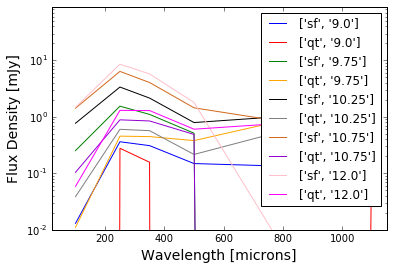

stacking 2 maps at 100
uds_pacs_green
cosmos_pacs_green
cfits_flat length: 44930960
stacking 2 maps at 250
uds_spire_PSW
cosmos_spire_PSW
cfits_flat length: 11877060
stacking 2 maps at 350
cosmos_spire_PMW
uds_spire_PMW
cfits_flat length: 12640000
stacking 2 maps at 500
uds_spire_PLW
cosmos_spire_PLW
cfits_flat length: 13198670
stacking 2 maps at 1100
cosmos_aztec
uds_aztec
cfits_flat length: 14334790


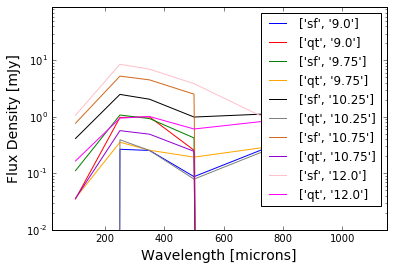

stacking 2 maps at 100
uds_pacs_green
cosmos_pacs_green
cfits_flat length: 34272670
stacking 2 maps at 250
uds_spire_PSW
cosmos_spire_PSW
cfits_flat length: 11169860
stacking 2 maps at 350
cosmos_spire_PMW
uds_spire_PMW
cfits_flat length: 12431740
stacking 2 maps at 500
uds_spire_PLW
cosmos_spire_PLW
cfits_flat length: 13113410
stacking 2 maps at 1100
cosmos_aztec
uds_aztec
cfits_flat length: 13733100


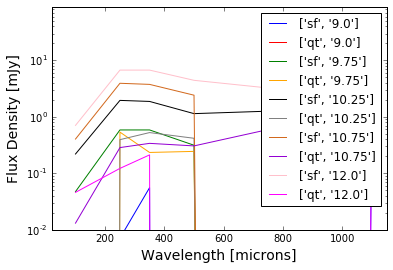

stacking 2 maps at 100
uds_pacs_green
cosmos_pacs_green
cfits_flat length: 21983320
stacking 2 maps at 250
uds_spire_PSW
cosmos_spire_PSW
cfits_flat length: 9259960
stacking 2 maps at 350
cosmos_spire_PMW
uds_spire_PMW
cfits_flat length: 11559150
stacking 2 maps at 500
uds_spire_PLW
cosmos_spire_PLW
cfits_flat length: 12864850
stacking 2 maps at 1100
cosmos_aztec
uds_aztec
cfits_flat length: 11599140


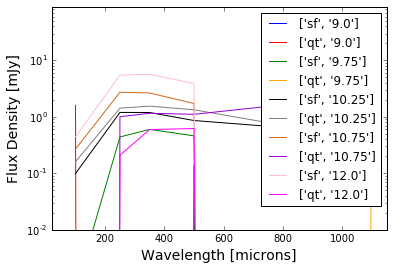

stacking 2 maps at 100
uds_pacs_green
cosmos_pacs_green
cfits_flat length: 15523840
stacking 2 maps at 250
uds_spire_PSW
cosmos_spire_PSW
cfits_flat length: 7724950
stacking 2 maps at 350
cosmos_spire_PMW
uds_spire_PMW
cfits_flat length: 10491010
stacking 2 maps at 500
uds_spire_PLW
cosmos_spire_PLW
cfits_flat length: 12448210
stacking 2 maps at 1100
cosmos_aztec
uds_aztec
cfits_flat length: 9667450


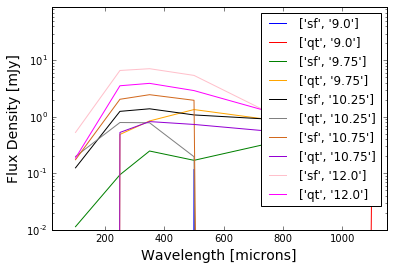

stacking 2 maps at 100
uds_pacs_green
cosmos_pacs_green
cfits_flat length: 8833450
stacking 2 maps at 250
uds_spire_PSW
cosmos_spire_PSW
cfits_flat length: 5164990
stacking 2 maps at 350
cosmos_spire_PMW
uds_spire_PMW
cfits_flat length: 8023270
stacking 2 maps at 500
uds_spire_PLW
cosmos_spire_PLW
cfits_flat length: 11093950
stacking 2 maps at 1100
cosmos_aztec
uds_aztec
cfits_flat length: 7014170


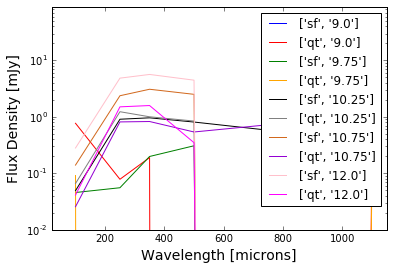

stacking 2 maps at 100
uds_pacs_green
cosmos_pacs_green
cfits_flat length: 1705760
stacking 2 maps at 250
uds_spire_PSW
cosmos_spire_PSW
cfits_flat length: 1217160
stacking 2 maps at 350
cosmos_spire_PMW
uds_spire_PMW
cfits_flat length: 2279940
stacking 2 maps at 500
uds_spire_PLW
cosmos_spire_PLW
cfits_flat length: 4335800
stacking 2 maps at 1100
cosmos_aztec
uds_aztec
cfits_flat length: 1648780


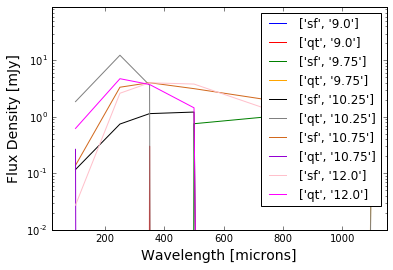

In [14]:
#Stack by Z, M, SF/QT
pop = ['sf','qt']
npop=2
all_stacked_fluxes_gaussians = np.zeros([nwv,nz,nm,npop])
all_luminosity_temp_gaussians= np.zeros([nz,nm,npop,2])

for iz in range(nz):
    zn = z_nodes[iz:iz+2]
    allFields.get_sf_qt_mass_redshift_bins(zn,m_nodes)
    radec_m_z_p = allFields.subset_positions(allFields.id_z_ms)
    stacked_fluxes_gaussians =  None
    n_sources_max = None
    
    stacked_fluxes_gaussians = stack_multiple_fields_in_redshift_slices(
        sky_library_gaussians,
        radec_m_z_p)
    
    #pdb.set_trace()
    args = radec_m_z_p.keys()
    for iwv in range(nwv):
        stacked_fluxes_wv = stacked_fluxes_gaussians[str(uwavelength[iwv])]
        for j in range(nm):
            for k in range(npop):
                arg = 'z_'+str(zn[0])+'-'+str(zn[1])+'__m_'+str(m_nodes[j])+'-'+str(m_nodes[j+1])+'_'+pop[k]
                #pdb.set_trace()
                all_stacked_fluxes_gaussians[iwv,iz,j,k] = stacked_fluxes_wv[arg.replace('.','p').replace('-','_')].value
    
    #pdb.set_trace()
    #PLOT
    plt.ylim([-1e-1,3e0])
    plt.ylim([1e-2,9e1])
    plt.xlim([20,510])
    plt.xlim([20,1150])
    plt.yscale('log')
    plt.ylabel('Flux Density [mJy]',fontsize=14)
    plt.xlabel('Wavelength [microns]',fontsize=14)
    for j in range(nm): 
        for k in range(npop):
            plt.plot(uwavelength,1e3*all_stacked_fluxes_gaussians[:,iz,j,k],color=popcolor[npop*j+k],label=[pop[k],str(m_mid[j])])
            plt.legend()
    plt.show()   
    #pdb.set_trace()

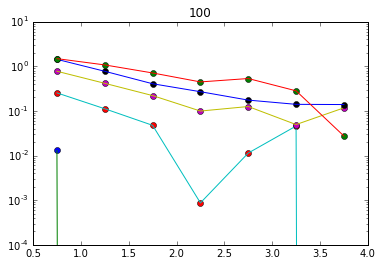

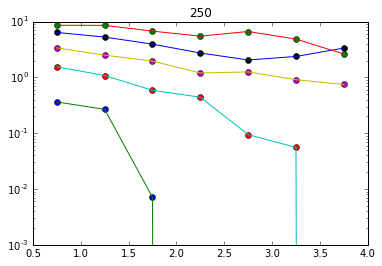

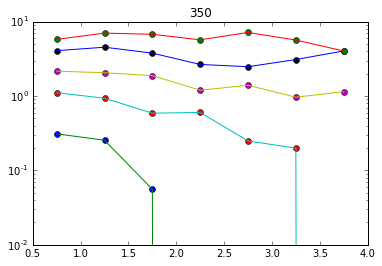

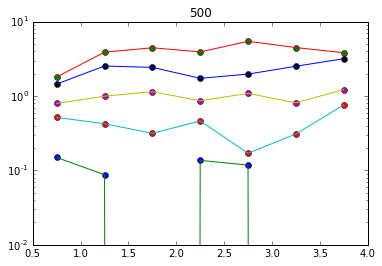

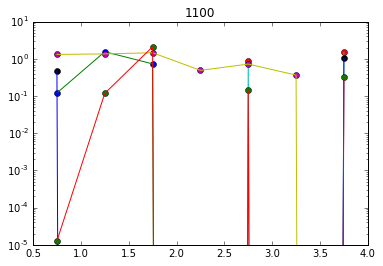

In [15]:
for iwv in range(nwv):
    plt.figure()
    for j in range(nm):
        
        #print 1e3*all_stacked_fluxes_gaussians[iwv,:,j,0]
        plt.yscale('log')
        plt.title(str(uwavelength[iwv]))
        plt.plot(z_mid,1e3*(all_stacked_fluxes_gaussians[iwv,:,j,0]),'o')
        plt.plot(z_mid,1e3*(all_stacked_fluxes_gaussians[iwv,:,j,0]))
    plt.show()